# Semantic Segmentation

Each person in the picture corresponds to a certain value in the mask. However, in this exercise we are interested in _semantic_ segmentation and not _instance_ segmentation, so we will consider all people as part of the same class. This means that we have two classes: people, and background (i.e., it is a binary segmentation):

<center><img src="images/semantic_segmentation.png" width="70%"></center>

In [1]:
import albumentations as A
from semantic_segmentation_helpers import PennFudanDataset
from semantic_segmentation_helpers import get_data_loaders
import matplotlib.pyplot as plt
from torch import nn
import torch
import segmentation_models_pytorch as smp
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import random
import metrics
import numpy as np
import cv2
import os
import glob
import livelossplot

# Seed random generator for repeatibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### Transforms for Semantic Segmentation

It is very important that all the geometric transformations that we apply as part of data augmentation are applied to both the image and the mask, otherwise the mask would not represent the semantic information in the image.

For this, we use the nice `albumentations` library that provides transformations that take care of that automatically. If you are curious to know how this is accomplished, consider this code in the `helpers.py` file, within the `PennFudanDataset` class:

```python
if self.transforms is not None:
    aug = self.transforms(image=img, mask=mask)
    img, mask = aug['image'], aug['mask']
```
As you can see, the transformations (contained in `self.transforms`) are applied to both the image and the mask.

We define two sets of transformations, one for the training set (containing augmentations) and one for the validation set (without augmentations).

> Since the dataset is small (there are only a total of 170 images) we cannot afford to divide it 3 ways (train, validation, and test). We therefore only divide it in two (train and validation). In a real-world use case, you would do k-fold cross-validation and repeat this split multiple times, recording the results of your training for each one of those. Here, for simplicity and to save time, we will not do that and will just train on the training dataset and evaluate on the validation dataset.

In [2]:
# The input of a UNET with 5 downsampling operations needs to be 
# divisible by 2**5 = 32 in both width and height. For simplicity we use square images
SIZE = 448

train_transforms = A.Compose(
    [
        # We first pad to make sure we have a dimension of
        # at least SIZE x SIZE. If padding is needed (image smaller than SIZE x SIZE), 
        # then a constant padding with green color is added
        A.PadIfNeeded(SIZE, SIZE, border_mode=0, value=(0, 255, 0)),
        # use a random crop instead of a center crop
        A.RandomCrop(SIZE, SIZE),
        # See the manual of the Albumentations package for what each one of these do
        A.HorizontalFlip(),
        A.OneOf(
            [
                A.OpticalDistortion(p=0.3),
                A.GridDistortion(p=0.1),
                A.PiecewiseAffine(p=0.3),
            ],
            p=0.3,
        ),
        A.OneOf(
            [
                A.HueSaturationValue(10, 15, 10),
                A.CLAHE(clip_limit=2),
                A.RandomBrightnessContrast(),
            ],
            p=0.3,
        ),
        A.Normalize(PennFudanDataset.mean, PennFudanDataset.std),
        A.pytorch.ToTensorV2(),
    ]
)

valid_transforms = A.Compose(
    [
        A.PadIfNeeded(SIZE, SIZE, border_mode=0, value=(0, 255, 0)),
        A.CenterCrop(SIZE, SIZE),
        A.Normalize(PennFudanDataset.mean, PennFudanDataset.std),
        A.pytorch.ToTensorV2(),
    ]
)

In [3]:
dl = get_data_loaders(
    "data/PennFudanPed", train_transforms, valid_transforms, num_workers=-1, batch_size=4
)

## Model
We are going to use a UNet architecture:

<center><img src="images/unet_architecture.png" width="70%"></center>

We use [efficientnet-b2](https://paperswithcode.com/method/efficientnet) as backbone, pre-trained on ImageNet:

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

model = smp.Unet(
        encoder_name='efficientnet-b2',
        encoder_weights='imagenet',
        in_channels=3,
        # Binary classification
        classes=1)

## Training

We use the Dice loss, which directly optimizes the IoU metric that we are interested in. We also use a different learning rate for the backbone/encoder (the pre-trained EfficientNet) and the decoder (which is new and needs to be trained from scratch). We want the weights in the decoder to move much more quickly than the weights in the encoder, since the encoder has been trained on ImageNet and is therefore already a very good feature extractor.

In [5]:
loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

optimizer = torch.optim.Adam([
    {'params': model.decoder.parameters(), 'lr': 1e-1},
    {'params': model.encoder.parameters(), 'lr': 1e-3},
])

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_one_epoch(epoch, model, data_loaders, optimizer, loss_function):
    model.train()
    model.to(device)
    
    ### Training
    train_loss = 0
    for batch, (imgs, masks) in tqdm(
        enumerate(data_loaders["train"]), total=len(data_loaders["train"]), ncols=60
    ):
        optimizer.zero_grad()
        
        # Move images and masks to the GPU (if available)
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = model(imgs)
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        train_loss += loss.item()
    
    # Compute average loss for this epoch
    train_loss /= len(data_loaders["train"])

    ### Validating
    model.eval()
    
    # Loop and accumulate the validation loss, as well as the 
    # True Positives, False Positives, False Negatives, True Negatives.
    # We will use these to compute the Intersection over Union metric
    # at the end of the validation phase
    valid_loss = 0
    tp, fp, fn, tn = [0] * 4

    with torch.no_grad():
        for batch, (imgs, masks) in tqdm(
            enumerate(data_loaders["valid"]), total=len(data_loaders["valid"]), ncols=60
        ):
            imgs = imgs.to(device)
            masks = masks.to(device)
            outputs = model(imgs)
            loss = loss_function(outputs, masks)
            valid_loss += loss.item()

            # Compute statistics for true positives, false positives, false negative and
            # true negative "pixels"
            this_tp, this_fp, this_fn, this_tn = metrics.get_stats(
                outputs.squeeze(), masks.squeeze(), mode="binary", threshold=0.5
            )

            tp += this_tp
            fp += this_fp
            fn += this_fn
            tn += this_tn

    # compute Intersection Over Union
    iou_score = metrics.iou_score(sum(tp), sum(fp), sum(fn), sum(tn), reduction="micro")

    valid_loss /= len(data_loaders["valid"])

    return train_loss, valid_loss, iou_score

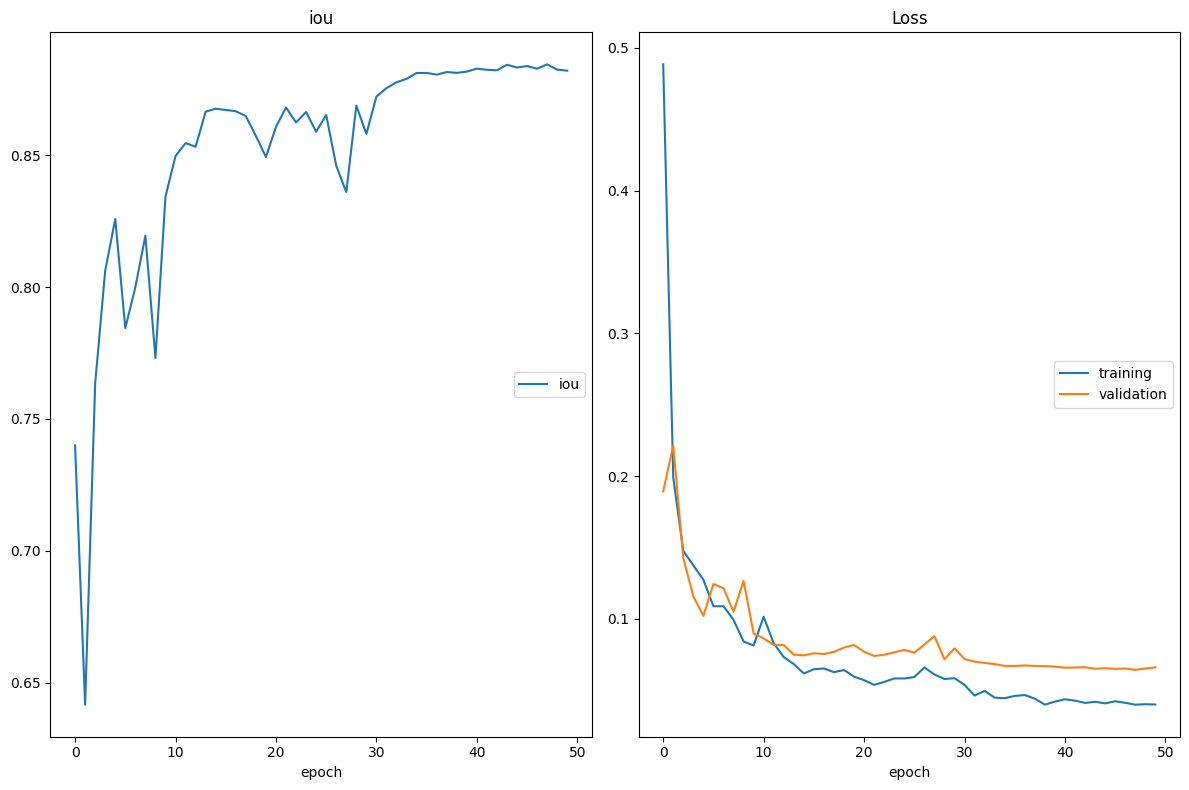

iou
	iou              	 (min:    0.642, max:    0.884, cur:    0.882)
Loss
	training         	 (min:    0.040, max:    0.488, cur:    0.040)
	validation       	 (min:    0.064, max:    0.221, cur:    0.066)


In [7]:
liveloss = livelossplot.PlotLosses()
logs = {}

# Reduce the learning rate by a factor of 10 every 30 epochs
scheduler = StepLR(optimizer, step_size=30, gamma=0.1, verbose=False)

for epoch in range(50):
    train_loss, valid_loss, iou = train_one_epoch(epoch, model, dl, optimizer, loss)
    print(f"EPOCH: {epoch + 1} - train loss: {train_loss} -  valid_loss: {valid_loss} - IoU: {iou:.3f}")
    
    logs["loss"] = train_loss
    logs["val_loss"] = valid_loss
    logs["iou"] = iou.data.item()
    
    liveloss.update(logs)
    liveloss.send()
    
    scheduler.step()

## Result

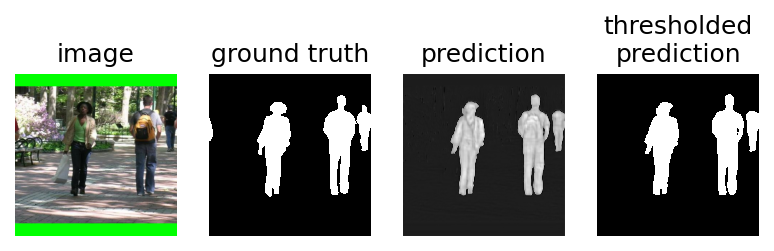

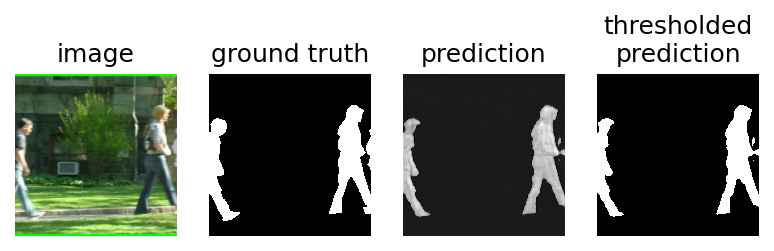

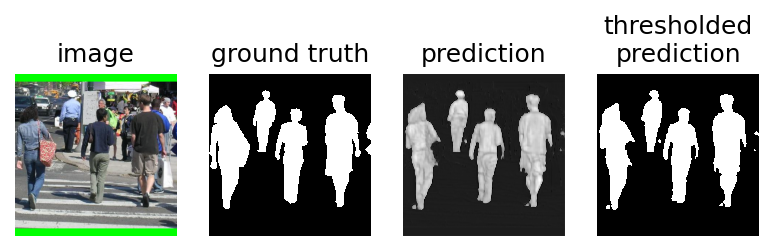

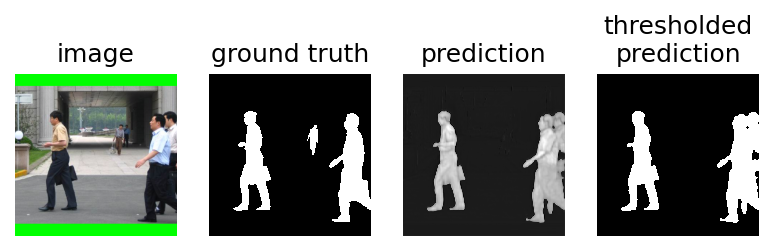

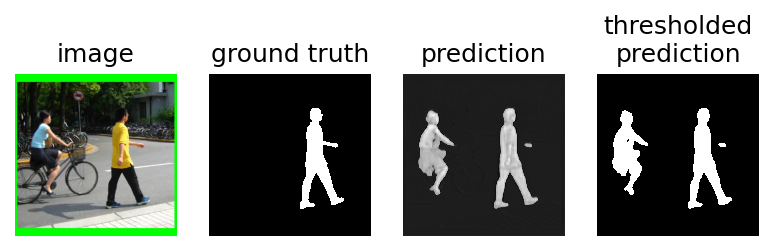

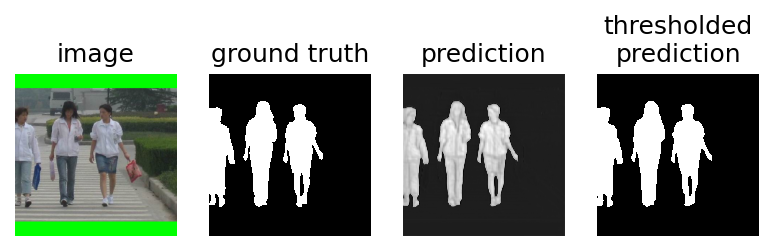

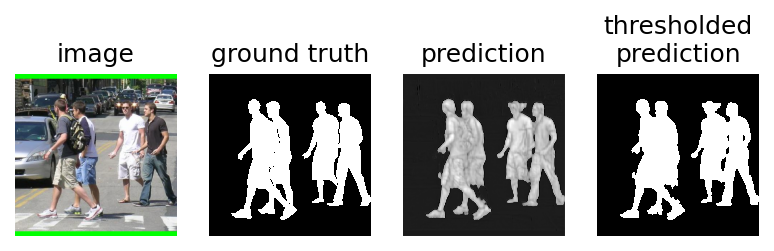

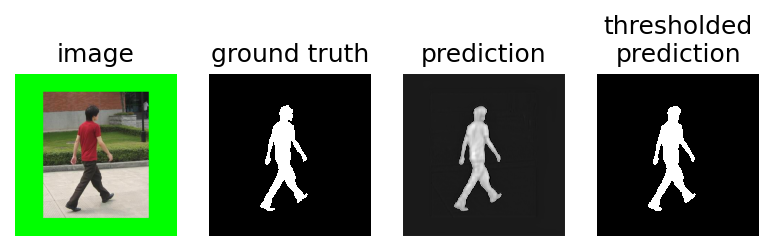

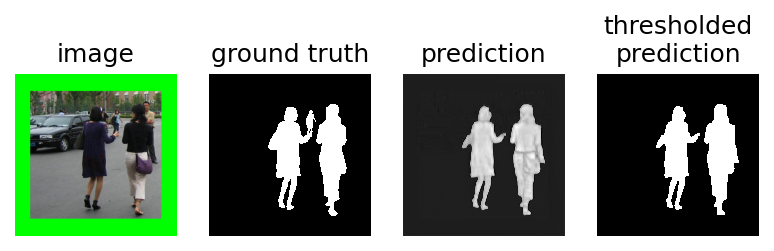

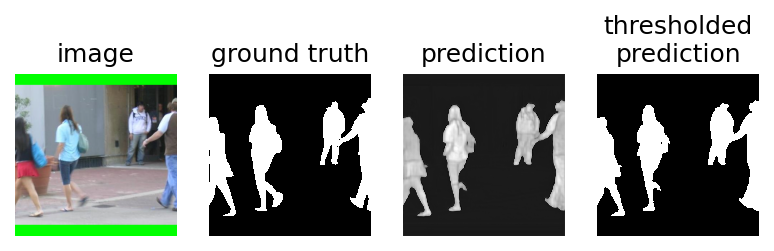

In [8]:
import torchvision.transforms as T
import numpy as np

def plot_some_results(n=10):
    
    valid_it = iter(dl['valid'])
    
    for _ in range(n):

        image, gt_mask = next(valid_it)
        with torch.no_grad():
            pred = model(image.cuda())[0]

        # Invert the T.Normalize transform
        unnormalize = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean = [ 0., 0., 0. ], std = 1 / PennFudanDataset.std),
                T.Normalize(mean = -PennFudanDataset.mean, std = [ 1., 1., 1. ])
            ]
        )

        image = (unnormalize(image.squeeze().numpy().T) * 255).numpy().astype(np.uint8)

        fig, ax = plt.subplots(1, 4, dpi=150)

        _ = ax[0].imshow(image.T)
        _ = ax[1].imshow(gt_mask.squeeze() * 255, cmap='gray', interpolation='none')
        _ = ax[2].imshow(pred.cpu().squeeze(), cmap='gray', interpolation='none')
        _ = ax[3].imshow((pred.cpu().squeeze() > 0) * 255, cmap='gray', interpolation='none')

        _ = [sub.axis("off") for sub in ax.flatten()]
        ax[0].set_title("image")
        ax[1].set_title("ground truth")
        ax[2].set_title("prediction")
        ax[3].set_title("thresholded\nprediction")

plot_some_results()

In general, our model seems to perform very well given how little data it has seen. It's not perfect though. We can also see that sometimes the ground truth itself is imprecise and sometimes our model is actually better than the ground truth.

We can see here a few more interesting things. Looking at the prediction column (which is the output of the model as is), we can see that the people have structures that resemble their clothing. 

> why that is the case?

Because UNet takes the tensor coming from the upsampling operations and sums it with the feature maps corresponding to that level in the decoder. In particular, the input image as-is gets summed to the output of the last layer in the decoder. Therfore some sharp features in the input image get projected into the prediction of the model.

It is also clear that our model underperforms on small "objects" (e.g., people far away). Small objects are classically difficult for both segmentation and object detection models. You can try to improve the situation by using a different loss, like the [Focal Tversky Loss](https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5).